In [69]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils import to_categorical

from keras.models import Input, Model
from keras.layers import Embedding, LSTM, Dense
import numpy as np
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu

In [70]:
def get_data_as_words(data_path = 'fra-eng/final_qa_data.csv', num_samples = 269):
    tokenizer_en = Tokenizer(num_words=None, filters='"#$%&()*+,/:;=?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ",
               char_level=False)
    tokenizer_fr = Tokenizer(num_words=None, filters='',
                   lower=True,
                   split=" ",
                   char_level=False)
    
    english_sentences = []
    french_sentences = []
    
    lines = open(data_path,encoding='utf8').read().split('\n')
    for line in lines[: min(num_samples, len(lines) - 1)]:
        line_split = line.split(',')
        english_sentence = [line_split[0].replace('.',' . ').replace('!',' ! ').replace('?',' ? ').replace(',',' , ').replace("'"," '")]
        english_sentences = english_sentences + english_sentence
        french_sentence = ['<START> ' 
                            + line_split[1].replace('.',' . ').replace('\u202f',' ').replace('!',' ! ').replace('?',' ? ').replace(',',' , ').replace("'"," '")
                            + '<STOP>']
        french_sentences = french_sentences + french_sentence

    tokenizer_en.fit_on_texts(english_sentences)
    tokenizer_fr.fit_on_texts(french_sentences)
    
    idx2Word_en={0:'<PAD>'}
    for key, value in tokenizer_en.word_index.items():
        idx2Word_en[value] = key
    
    idx2Word_fr={0:'<PAD>'}
    for key, value in tokenizer_fr.word_index.items():
        idx2Word_fr[value] = key
    
    
    encoder_input_data = tokenizer_en.texts_to_sequences(english_sentences)
    encoder_input_data = pad_sequences(encoder_input_data, maxlen=None, dtype='int32', padding='post', truncating='post', value=0)
    french_tokenized = tokenizer_fr.texts_to_sequences(french_sentences)
    french_tokenized = pad_sequences(french_tokenized, maxlen=None, dtype='int32', padding='post', truncating='post', value=0)
    decoder_input_data = french_tokenized[:,:-1]
    decoder_target_data = french_tokenized[:,1:]
    word2Idx_en = tokenizer_en.word_index
    word2Idx_fr = tokenizer_fr.word_index
    num_encoder_tokens = len(idx2Word_en)
    num_decoder_tokens = len(idx2Word_fr)
    decoder_target_data_cat = to_categorical(decoder_target_data.reshape(1,-1)[0]).reshape(len(decoder_target_data), decoder_target_data.shape[1], num_decoder_tokens)
    
    return english_sentences, french_sentences, \
            encoder_input_data, \
            decoder_input_data, \
            decoder_target_data_cat, \
            num_encoder_tokens, num_decoder_tokens, \
            idx2Word_en, idx2Word_fr, \
            word2Idx_en, word2Idx_fr

In [71]:
def get_words_embedding_model_inference(num_encoder_tokens, num_decoder_tokens, latent_dim = 256):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,))
    x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
    x, state_h, state_c = LSTM(latent_dim,
                            return_state=True)(x)
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))
    decoder_embedd = Embedding(num_decoder_tokens, latent_dim)
    x = decoder_embedd(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    x,_,_ = decoder_lstm(x, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(x)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(latent_dim,), name="State_input_h")
    decoder_state_input_c = Input(shape=(latent_dim,), name="State_input_c")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    x = decoder_embedd(decoder_inputs)
    decoder_outputs, state_h, state_c = decoder_lstm(x, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    return model, encoder_model, decoder_model

In [72]:
def get_words_embedding_model(num_encoder_tokens, num_decoder_tokens, latent_dim = 256):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,))
    x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
    x, state_h, state_c = LSTM(latent_dim,
                            return_state=True)(x)
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))
    decoder_embedd = Embedding(num_decoder_tokens, latent_dim)
    x = decoder_embedd(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    x,_,_ = decoder_lstm(x, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(x)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model


In [73]:
def main():
    num_samples = 269
    english_sentences, french_sentences, \
    encoder_input_data, decoder_input_data, decoder_target_data, \
    num_encoder_tokens, num_decoder_tokens, \
    idx2Word_en, idx2Word_fr, \
    word2Idx_en, word2Idx_fr = get_data_as_words(num_samples = num_samples)
    latent_dim = 128
    model = get_words_embedding_model(num_encoder_tokens, num_decoder_tokens, latent_dim = latent_dim)
    model.summary()
    # Compile & run training
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    # Note that `decoder_target_data` needs to be one-hot encoded,
    # rather than sequences of integers like `decoder_input_data`!
    epochs = 10
    batch_size = 128
    file_name = 'seq2seq_enc_dec_model_'+str(latent_dim)+'_'+str(num_samples)
    checkpoint = ModelCheckpoint(file_name+'_best.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
    callbacks_list = [checkpoint]
    model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2,
              callbacks = callbacks_list)

    file_name = 'seq2seq_enc_dec_model_'+str(latent_dim)+'_'+str(num_samples)
    #model.save_weights(file_name+'.hdf5')
    np.save(file_name, model.history.history)

if __name__ == "__main__": main()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, None, 128)    36864       input_17[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, None, 128)    33664       input_18[0][0]                   
__________________________________________________________________________________________________
lstm_17 (L

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\topology.py:2344: UserWarning: Layer lstm_18 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_17/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_17/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


209/209 [==============================] - 8s 39ms/step - loss: 5.5494 - val_loss: 5.3072
Epoch 2/10
209/209 [==============================] - 1s 5ms/step - loss: 5.2748 - val_loss: 2.8544
Epoch 3/10
209/209 [==============================] - 1s 5ms/step - loss: 3.3844 - val_loss: 1.6801
Epoch 4/10
209/209 [==============================] - 1s 5ms/step - loss: 2.9714 - val_loss: 1.6937
Epoch 5/10
209/209 [==============================] - 1s 5ms/step - loss: 2.8891 - val_loss: 1.6537
Epoch 6/10
209/209 [==============================] - 1s 5ms/step - loss: 2.8256 - val_loss: 1.6409
Epoch 7/10
209/209 [==============================] - 1s 5ms/step - loss: 2.7583 - val_loss: 1.6669
Epoch 8/10
209/209 [==============================] - 1s 5ms/step - loss: 2.7646 - val_loss: 2.0452
Epoch 9/10
209/209 [==============================] - 1s 6ms/step - loss: 2.9202 - val_loss: 1.5749
Epoch 10/10
209/209 [==============================] - 1s 5ms/step - loss: 2.6626 - val_loss: 1.5304


In [74]:
decoder_target_data.shape

(262, 26, 263)

In [75]:
num_samples = 269 #28500
latent_dim = 128 #256
english_sentences, french_sentences, \
encoder_input_data, decoder_input_data, decoder_target_data, \
num_encoder_tokens, num_decoder_tokens, \
idx2Word_en, idx2Word_fr, \
word2Idx_en, word2Idx_fr = get_data_as_words(num_samples = num_samples)

model, encoder_model, decoder_model = get_words_embedding_model_inference(num_encoder_tokens, num_decoder_tokens, latent_dim = latent_dim)
model.summary()
encoder_model.summary()
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, None, 128)    36864       input_19[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, None, 128)    33664       input_20[0][0]                   
__________________________________________________________________________________________________
lstm_19 (L

In [81]:
max_decoder_seq_length = decoder_target_data.shape[1]
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.array([word2Idx_fr['<start>']])
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_char = idx2Word_fr[sampled_token_index]
        decoded_sentence = decoded_sentence + sampled_char + ' '

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<stop>' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.array([sampled_token_index])

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [82]:
### 0, 10, 19, 1000, 1001
def translate(sec_n = 0):
    input_seq = encoder_input_data[sec_n:sec_n+1]
    # print([idx2Word_en[word] for word in input_seq[0]])
    decoded_sentence = decode_sequence(input_seq)
    return decoded_sentence.replace('<stop>','').split(), \
        french_sentences[sec_n].replace('<START>','').replace('<STOP>','').lower().split()

def get_ref_and_cand(english_sentences, french_sentences, number_translations):
    english_sentences_np = np.array(english_sentences)
    french_sentences_as_list = [sen.replace('<START>','').replace('<STOP>','').lower().split() for sen in french_sentences]
    french_sentences_np = np.array(french_sentences_as_list)
    print('Creating references indexes')
    reference_indexes = []
    for eng_np in english_sentences_np:
        indxs = np.array(np.where(english_sentences_np==eng_np)[0])
        if (len(reference_indexes)>0):
            if len(reference_indexes[-1])!=len(indxs):
                result = 0
            else:
                result = (reference_indexes[-1] == indxs).prod()  
            if (result==0):
                reference_indexes.append(indxs)
        else:
            reference_indexes.append(indxs)
    print('Creating references and translating')
    references = []
    candidates = []
    count = 0
    for ref_idx  in reference_indexes[:number_translations]:
        reference = list(french_sentences_np[ref_idx])
        references.append(reference)
        candidates.append(translate(count)[0])
        count = count+len(reference)
    print('Created!')
    return references, candidates
references, candidates = get_ref_and_cand(english_sentences, french_sentences, 262)

Creating references indexes
Creating references and translating


ValueError: Error when checking model : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([2])]...

In [36]:
candidates[:10]

[['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi'],
 ['ils', 'donne-les-moi']]

In [33]:
score = corpus_bleu(references, candidates)
print(score)

history = np.load('seq2seq_enc_dec_model_128_1000.npy')
from matplotlib import pyplot as plt

0.14241131333821394


C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


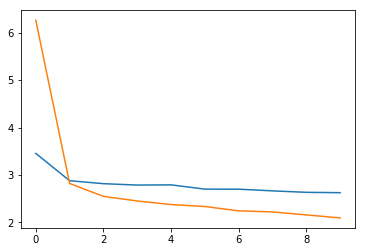

In [34]:
plt.plot(history.reshape(1)[0]['val_loss'])
plt.plot(history.reshape(1)[0]['loss'])
plt.show()